###Data Dictionaries

Candidates table --> http://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20Candidates%20Data.htm

PACs table --> http://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20for%20PAC%20to%20Cands%20Data.htm

In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load tables
cands = pd.read_table('cands12_copy3.txt', delimiter=',', na_values=[' ', '    '])
pacs = pd.read_table('pacs12_copy.txt', delimiter=',')

In [3]:
cands.head()

,cycle,fec_cand_id,cid,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,Unnamed: 12
0,2012,H2NC08219,N00034999,Antonio Blue (D),D,NC08,NaN,NaN,Y,C,DC,NaN,NaN
1,2012,H2VI00082,N00035000,Stacey Plaskett (D),D,VI00,NaN,NaN,Y,C,DN,NaN,NaN
2,2012,S2NY00317,N00035001,Tim Sweet (I),I,NYS1,NaN,Y,Y,C,3L,NaN,NaN
3,2012,P20005104,N00035002,Maura Deluca (3),3,PRES,NaN,NaN,NaN,NaN,3N,NaN,NaN
4,2012,P20005120,N00035003,Colin David Teberg (U),U,PRES,NaN,NaN,NaN,NaN,UN,NaN,NaN


In [4]:
pacs.head()

,cycle,fec_rec_no,pac_id,cid,amount,date,real_code,type,di,fec_cand_id
0,2012,4101720121167459916,C00279380,N00027694,1500,09/25/2012,LT500,24K,D,S6MO00305
1,2012,4020120121150250973,C00279455,N00027510,1000,04/01/2011,H4300,24K,D,H6CO07023
2,2012,4121720121176010367,C00347385,N00001861,1000,09/20/2012,C4000,24K,D,H6CA24048
3,2012,4042520121155267132,C00034272,N00004227,2000,03/27/2012,A2300,24K,D,H4IA05102
4,2012,4111520121172245411,C00000729,N00007335,1000,10/10/2012,H1400,24K,D,H8CA12098


In [5]:
cands = cands.drop(cands.columns[-1], axis=1) #drop extra column

In [6]:
cands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 12 columns):
cycle           5952 non-null int64
fec_cand_id     5952 non-null object
cid             5952 non-null object
first_last_p    5952 non-null object
party           5952 non-null object
distid_run      5952 non-null object
distid_cur      569 non-null object
cur_cand        1409 non-null object
cycle_cand      2984 non-null object
crpico          3266 non-null object
recip_code      5952 non-null object
no_pacs         7 non-null object
dtypes: int64(1), object(11)
memory usage: 604.5+ KB


In [7]:
pacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394542 entries, 0 to 394541
Data columns (total 10 columns):
cycle          394542 non-null int64
fec_rec_no     394542 non-null int64
pac_id         394542 non-null object
cid            394461 non-null object
amount         394542 non-null int64
date           394525 non-null object
real_code      394542 non-null object
type           394542 non-null object
di             394542 non-null object
fec_cand_id    394540 non-null object
dtypes: int64(3), object(7)
memory usage: 33.1+ MB


In [8]:
#make new column 'race_type'
def group_titles(x):
    if 'PRES' in x:
        return 'PRES'
    elif x.find('S') == 2:
        return 'SEN'
    else:
        return 'HOUSE'

In [9]:
cands['race_type'] = cands.distid_run.apply(group_titles)

In [10]:
cands.head()

,cycle,fec_cand_id,cid,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,race_type
0,2012,H2NC08219,N00034999,Antonio Blue (D),D,NC08,NaN,NaN,Y,C,DC,NaN,HOUSE
1,2012,H2VI00082,N00035000,Stacey Plaskett (D),D,VI00,NaN,NaN,Y,C,DN,NaN,HOUSE
2,2012,S2NY00317,N00035001,Tim Sweet (I),I,NYS1,NaN,Y,Y,C,3L,NaN,SEN
3,2012,P20005104,N00035002,Maura Deluca (3),3,PRES,NaN,NaN,NaN,NaN,3N,NaN,PRES
4,2012,P20005120,N00035003,Colin David Teberg (U),U,PRES,NaN,NaN,NaN,NaN,UN,NaN,PRES


In [11]:
# make column 'state' for race location
def states(x):
    if not 'PRES' in x:
        return x[0:2]
    
cands['state'] = cands.distid_run.apply(states)

In [12]:
# make column 'district' for seat run for
def district(x):
    if not 'PRES' in x:
        return x[2:]

cands['district'] = cands.distid_run.apply(district)

In [13]:
# the last letter in 'recip_code' indicates win or lose, pull that out first, then make 'win' column
cands['result'] = cands['recip_code'].str[1]

In [14]:
def win(x):
    if 'L' in x:
        return 0
    elif 'W' in x:
        return 1

cands['win'] = cands['result'].apply(win)

In [15]:
# 'no_pacs' might not be a useful column since only 7 candidates elected not to receive donations from PACS
# but nevertheless fill NaNs to be 0, set 'Y' == 1 in new column 'no_pacs_bin'
cands['no_pacs_bin'] = cands.no_pacs.apply(lambda x: 1 if x == 'Y' else int(0))

In [16]:
# distid_cur == NaN if non incumbent. fill nan == 0, make new incumbent column
cands['distid_cur'] = cands.distid_cur.fillna(0)
cands['incumbent'] = cands.distid_cur.apply(lambda x: 1 if x != 0 else int(0))

In [17]:
# since the cycle is always 2012, can drop that column
# and cid column (campaign id), since no information contained there
cands = cands.drop(cands.columns[[0,2]], axis=1)

In [18]:
cands.head()

,fec_cand_id,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,race_type,state,district,result,win,no_pacs_bin,incumbent
0,H2NC08219,Antonio Blue (D),D,NC08,0,NaN,Y,C,DC,NaN,HOUSE,NC,08,C,NaN,0,0
1,H2VI00082,Stacey Plaskett (D),D,VI00,0,NaN,Y,C,DN,NaN,HOUSE,VI,00,N,NaN,0,0
2,S2NY00317,Tim Sweet (I),I,NYS1,0,Y,Y,C,3L,NaN,SEN,NY,S1,L,0,0,0
3,P20005104,Maura Deluca (3),3,PRES,0,NaN,NaN,NaN,3N,NaN,PRES,None,None,N,NaN,0,0
4,P20005120,Colin David Teberg (U),U,PRES,0,NaN,NaN,NaN,UN,NaN,PRES,None,None,N,NaN,0,0


In [19]:
#get total amount donated to each candidate by all PACs
pacs_grouped = pacs.groupby('fec_cand_id').sum()

In [20]:
pacs_grouped.head()

,cycle,fec_rec_no,amount
fec_cand_id,,,
H0AK00089,2012,4.092620e+18,-1000
H0AL02087,802788,1.608374e+21,535065
H0AL05163,694140,1.392243e+21,469727
H0AL05197,4024,6.164040e+18,5391
H0AL07060,2012,4.031620e+18,-1500


In [21]:
# can drop cycle and fec_rec_no (receipt) columns
pacs_grouped = pacs_grouped.drop(pacs_grouped.columns[[0,1]], axis=1)

In [22]:
#get number of times any PAC donated to each candidate
pacs_total = pacs.groupby('fec_cand_id').count()

In [23]:
pacs_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, H0AK00089 to S8WV00101
Data columns (total 9 columns):
cycle         1785 non-null int64
fec_rec_no    1785 non-null int64
pac_id        1785 non-null int64
cid           1785 non-null int64
amount        1785 non-null int64
date          1785 non-null int64
real_code     1785 non-null int64
type          1785 non-null int64
di            1785 non-null int64
dtypes: int64(9)
memory usage: 139.5+ KB


In [24]:
# the higher the count of pac_id, the more times a PAC donated to a candidate. This column cand be used 
# as a proxy for race length, since the more times a PAC donated the longer the race went
# drop all columns except pac_id before join
pacs_total = pacs_total.drop(pacs_total.columns[[0,1,3,4,5,6,7,8]], axis=1)

In [25]:
pacs_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, H0AK00089 to S8WV00101
Data columns (total 1 columns):
pac_id    1785 non-null int64
dtypes: int64(1)
memory usage: 27.9+ KB


In [26]:
#get unique number of PACs that donated to each candidate
pac_unique = pacs.groupby('fec_cand_id').pac_id.nunique()

In [27]:
pac_unique.head()

fec_cand_id
H0AK00089      1
H0AL02087    201
H0AL05163    159
H0AL05197      2
H0AL07060      1
Name: pac_id, dtype: int64

In [28]:
# join new data frames/columns into 'full' data frame
full = cands.join(pacs_grouped, on='fec_cand_id', how='left')
full = full.join(pac_unique, on='fec_cand_id', how='left')
full = full.join(pacs_total, on='fec_cand_id', how='left', lsuffix='_unique', rsuffix='_total')

In [29]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 20 columns):
fec_cand_id      5952 non-null object
first_last_p     5952 non-null object
party            5952 non-null object
distid_run       5952 non-null object
distid_cur       5952 non-null object
cur_cand         1409 non-null object
cycle_cand       2984 non-null object
crpico           3266 non-null object
recip_code       5952 non-null object
no_pacs          7 non-null object
race_type        5952 non-null object
state            5365 non-null object
district         5365 non-null object
result           5952 non-null object
win              2584 non-null float64
no_pacs_bin      5952 non-null int64
incumbent        5952 non-null int64
amount           1743 non-null float64
pac_id_unique    1743 non-null float64
pac_id_total     1743 non-null float64
dtypes: float64(4), int64(2), object(14)
memory usage: 976.5+ KB


In [30]:
#fill NaNs where NaN actually just equals 0
full['win'] = full.win.fillna(0)
full['amount'] = full.amount.fillna(0)
full['pac_id_unique'] = full.pac_id_unique.fillna(0)
full['pac_id_total'] = full.pac_id_total.fillna(0)

In [31]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 20 columns):
fec_cand_id      5952 non-null object
first_last_p     5952 non-null object
party            5952 non-null object
distid_run       5952 non-null object
distid_cur       5952 non-null object
cur_cand         1409 non-null object
cycle_cand       2984 non-null object
crpico           3266 non-null object
recip_code       5952 non-null object
no_pacs          7 non-null object
race_type        5952 non-null object
state            5365 non-null object
district         5365 non-null object
result           5952 non-null object
win              5952 non-null float64
no_pacs_bin      5952 non-null int64
incumbent        5952 non-null int64
amount           5952 non-null float64
pac_id_unique    5952 non-null float64
pac_id_total     5952 non-null float64
dtypes: float64(4), int64(2), object(14)
memory usage: 976.5+ KB


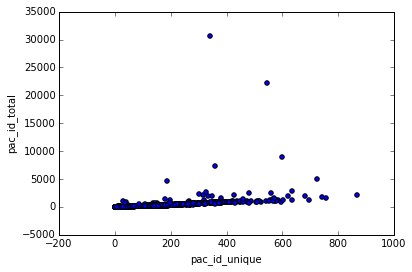

In [32]:
#plot number unique PACs donating to candidates vs. total number of donations to candidates from all PACs
full.plot(kind='scatter', x='pac_id_unique', y='pac_id_total')

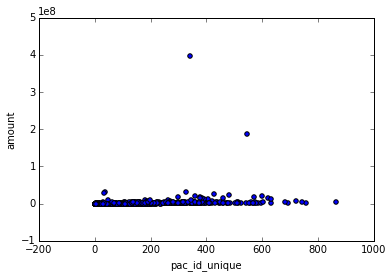

In [33]:
#plot amounts given to candidates by number unique PACS donating to candidates
full.plot(kind='scatter', x='pac_id_unique', y='amount')

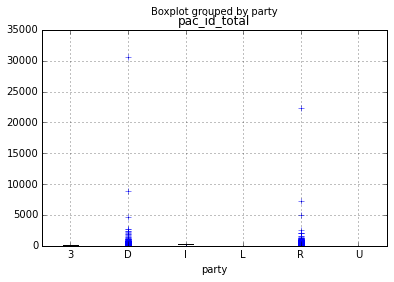

In [34]:
full.boxplot(column='pac_id_total', by='party') #more donations made to Dems than any other 

In [35]:
#get data ready for modeling
# Model 1
y, X = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(state) + C(district) + C(no_pacs_bin) + C(incumbent)', 
                       full, return_type='dataframe')
y = np.ravel(y)

In [36]:
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
dc = DummyClassifier()

rf.fit(X, y)
dc.fit(X, y)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [37]:
#compare results
print np.abs(cross_val_score(rf, X, y, scoring='accuracy', cv=10)).mean()
print np.abs(cross_val_score(dc, X, y, scoring='accuracy', cv=10)).mean()
#this random forest can predict with 96% accuracy the outcome of an election, compared to a dummy classifier with 
#83% accuracy

0.959731345102
0.828894870009


In [38]:
# test vs SVM
# scale features first
scale = StandardScaler()
X_train = scale.fit(X).transform(X)

In [39]:
svm = SVC()
svm.fit(X_train, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [40]:
print np.abs(cross_val_score(svm, X_train, y, scoring='accuracy', cv=10)).mean()
# SVM predicts with 95% accuracy, try again after rf feature importance

0.948913901749


In [41]:
#check feature importance
pd.set_option('display.float_format', lambda x: '%3f' % x)
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=X.columns).sort('importance')

,importance
C(district)[T.AS],0.000000
C(race_type)[T.PRES],0.000000
C(party)[U],0.000011
C(district)[T.38],0.000026
C(district)[T.50],0.000026
C(district)[T.37],0.000027
C(district)[T.46],0.000028
C(district)[T.53],0.000050
C(district)[T.45],0.000059
C(district)[T.42],0.000067


In [42]:
# somewhat not surprisingly, the most important features of this model are unique pacs donating, amount donated, 
# number of times donated, whether or not the candidate was an incumbent, the party, and race type
# may have over-complicated my model by splitting up state and district, might be worth it to try the model just by
# patsy-ing the original distid_run column

In [43]:
# Model 1a
y1, X1 = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent) + C(distid_run)',
                         full, return_type='dataframe')
y1 = np.ravel(y1)

In [49]:
rf1 = rf

rf1.fit(X1, y1)
print np.abs(cross_val_score(rf1, X1, y1, scoring='accuracy', cv=10)).mean()
# Slightly better prediction accuracy here as when I used State and District separately

0.963705938751


In [50]:
#check feature importance w/ distid_run instead of separate columns for state and district
pd.set_option('display.float_format', lambda x: '%3f' % x)
d1 = {'importance': rf1.feature_importances_}
pd.DataFrame(d1, index=X1.columns).sort('importance')

,importance
C(distid_run)[T.PA19],0.000000
C(distid_run)[T.NY28],0.000000
C(distid_run)[T.CA00],0.000000
C(distid_run)[T.IL19],0.000000
C(distid_run)[T.CT06],0.000000
C(distid_run)[T.ASAS],0.000000
C(distid_run)[T.NJ13],0.000000
C(distid_run)[T.NY00],0.000000
C(distid_run)[T.LA07],0.000000
C(distid_run)[T.IL00],0.000000


In [51]:
# new model including only important features
# Model 2
y_new, X_new = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent)',
                         full, return_type='dataframe')
y_new = np.ravel(y_new)

In [52]:
Xscale_new = scale.fit(X_new).transform(X_new)

In [53]:
rf1 = rf
dc1 = dc
svm1 = svm 

rf1.fit(X_new, y_new)
svm1.fit(Xscale_new, y_new)
dc1.fit(X_new, y_new)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [67]:
print np.abs(cross_val_score(rf1, X_new, y_new, scoring='accuracy', cv=10)).mean()
print np.abs(cross_val_score(svm1, Xscale_new, y_new, scoring='accuracy', cv=10)).mean()
print np.abs(cross_val_score(dc1, X_new, y_new, scoring='accuracy', cv=10)).mean()
# RF improves marginally from when many more features were included, but SVM improved

0.967066437313
0.963032823868
0.846277423721


In [ ]:
# try clustering after modeling with RF

In [56]:
from sklearn.cluster import KMeans

In [57]:
# use scaled data for clustering
km = KMeans()
km.fit(Xscale_new)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

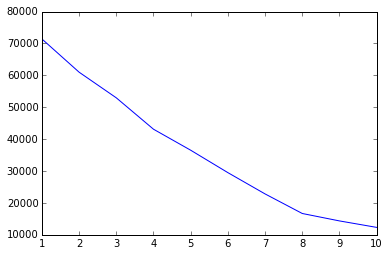

In [58]:
# graph inertia as clusters increase
inertia = []
k = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(Xscale_new)
    k.append(i)
    inertia.append(km.inertia_)
plt.plot(k, inertia)

# elbow test around 8

In [59]:
km = KMeans(n_clusters=8)
km.fit_predict(Xscale_new)

array([3, 3, 4, ..., 4, 3, 1], dtype=int32)

In [190]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,8)}
pd.DataFrame(columns, index=X_new.columns)

,0,1,2,3,4,5,6,7
C(party)[3],0.000,0.000,-0.000,0.000,1.000,0.000,-0.000,0.000
C(party)[D],0.459,1.000,-0.000,-0.000,-0.000,0.500,-0.000,0.000
C(party)[I],-0.000,-0.000,0.000,1.000,-0.000,0.000,-0.000,-0.000
C(party)[L],-0.000,-0.000,-0.000,-0.000,-0.000,0.000,1.000,-0.000
C(party)[R],0.541,-0.000,1.000,0.000,0.000,0.500,-0.000,-0.000
C(party)[U],0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,1.000
C(race_type)[T.PRES],0.005,0.042,0.069,0.256,0.308,1.000,0.084,0.585
C(race_type)[T.SEN],0.230,0.133,0.152,0.149,0.183,0.000,0.140,0.031
C(incumbent)[T.1],0.984,-0.000,0.000,0.004,0.000,0.500,0.000,-0.000
amount,1512491.911,100303.868,85487.825,9613.398,246.057,292776446.000,2301.492,131.292


### Some interesting clusters here:
0. House Incumbents 
1. House Democrat Challengers
2. House Republican Challengers
3. House Independent Challengers
4. House 3rd-Party Challengers
5. Romney vs. Obama  
6. House Libertarian Challengers
7. Unknown Presidential Hopefuls

In [60]:
full['clusters'] = km.labels_

In [61]:
# Model 3
y_cluster, X_cluster = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent) + C(clusters)',
                                full, return_type='dataframe')

y_cluster = np.ravel(y_cluster)

In [62]:
Xcluster_scale = scale.fit(X_cluster).transform(X_cluster)

In [63]:
rf2 = rf 
svm2 = svm
dc2 = dc

rf2.fit(X_cluster, y_cluster)
svm2.fit(Xcluster_scale, y_cluster)
dc2.fit(X_cluster, y_cluster)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [64]:
print np.abs(cross_val_score(rf2, X_cluster, y_cluster, scoring='accuracy', cv=10)).mean()
print np.abs(cross_val_score(svm2, Xcluster_scale, y_cluster, scoring='accuracy', cv=10)).mean()
print np.abs(cross_val_score(dc2, X_cluster, y_cluster, scoring='accuracy', cv=10)).mean()

0.969250465287
0.962697253398
0.847951328182


In [65]:
# Clustering didn't improve my model. Random Forest and SVM yield nearly the same accuracy of 96% vs a Dummy Classifier
# of 84% accuracy

In [68]:
# feature importance of last model
pd.set_option('display.float_format', lambda x: '%3f' % x)
d2 = {'importance': rf2.feature_importances_}
pd.DataFrame(d2, index=X_cluster.columns).sort('importance')

,importance
C(clusters)[T.7],0.000000
C(party)[U],0.000000
C(party)[L],0.000073
C(clusters)[T.6],0.000079
C(clusters)[T.5],0.000328
C(clusters)[T.4],0.000610
C(party)[3],0.000691
C(party)[I],0.000998
C(race_type)[T.PRES],0.002211
C(clusters)[T.3],0.003393
